This notebook shows an single-Gaussian fitting example of Na IX 681 line observed by SUMER. For the fitting of other SUMER lines, please check [338 window](https://github.com/yjzhu-solar/EIS_SUMER_PCH_Ti/blob/main/ipynb/sumer_fit/window_338_fit_poisson.ipynb), [375 window](https://github.com/yjzhu-solar/EIS_SUMER_PCH_Ti/blob/main/ipynb/sumer_fit/window_375_fit_poisson.ipynb), [507 window](https://github.com/yjzhu-solar/EIS_SUMER_PCH_Ti/blob/main/ipynb/sumer_fit/window_507_fit_poisson.ipynb), and [609 window](https://github.com/yjzhu-solar/EIS_SUMER_PCH_Ti/blob/main/ipynb/sumer_fit/window_609_fit_poisson.ipynb). 

In [6]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import scipy.io 
import sys
sys.path.append('/Users/yjzhu/Desktop/Solar/MyPy')
import juanfit
import importlib
importlib.reload(juanfit)
from juanfit import SpectrumFitSingle, SpectrumFitRow, gaussian, num_to_roman
from juanfit import gaussian
import cmcrameri.cm as cmcm
import sumerpy
import mycorner
importlib.reload(mycorner)
importlib.reload(sumerpy)
from num2tex import num2tex
from sumerpy import con_width_funct_4, radiometry

In [7]:
sumer_img = scipy.io.readsav("../../save/sumer_merg.sav")["int_merg"]
wvl_338 = np.linspace(0,1023,1024)*0.04496629878144223 + 671.7967194748996
sumer_338_window = sumer_img[:,:1024]
sumer_338_err = np.sqrt(sumer_338_window*300)
sumer_338_window.shape
sumer_ycen = 1119.81
sumer_ycoord = np.linspace(sumer_ycen-299.2/2,sumer_ycen+299.2/2,300) - 5
np.set_printoptions(precision=2)

In [8]:
class SpectrumFitCustomPlot(SpectrumFitSingle):
    def plot_custom(self, plot_fit=True,plot_params=True, plot_mcmc=False,plot_hmc=False,
                color_style="Red",plot_title=None,xlabel=None,ylabel=None,xlim=None,
                line_caption=None,save_fig=False,
                params_prec = {"int":2,"wvl":1,"fwhm":2,"cont":1},
                save_fname="./fit_result.pdf",save_fmt="pdf",save_dpi=300):
        '''
            Plot the input spectra and fitting results. 

            Parameters
            ----------
            plot_fit : bool, optional
            If True, plots the fitting results as well. Default is True.
            plot_params : bool, optional 
            If True, plot the fitted parameters by the figure. Default is True. 
            plot_mcmc : bool, optional 
            If True, plots the MCMC results. Default is False.
            plot_hmc: bool, optional 
            If True, plots the Monte Carlo fitting results using the method described in 
            Hahn et al. 2012, ApJ, 753, 36. Default is False. 
            xlim : [left limit, right_lim], optional 
            If provided, set the left and right limit of the x-axis. Default is None. 
            color_style : {"Red","Yellow","Green","Blue","Purple"}, optional
            Color style of the plot. Default is "Red".
            plot_title : string, optional 
            Set to be the title of the plot. Default is None.
            xlabel: string, optional 
            Set to be the label of the x-axis. Default is None.
            ylabel: string, optional 
            Set to be the label of the y-axis. Default is None. 
            save_fig: bool, optional 
            If True, save the plot to local directory. Default is False.
            save_fname: string, optional 
            The filename of the saved plot. Default is "./fit_result.pdf"
            save_fmt: string, optional 
            Format of the saved file, e.g., "pdf", "png", "svg"... Default is "pdf".
            save_dpi: int, optional
            Dots per inch (DPI) of the saved plot. Default is 300. 

        '''
        if (self.custom_func is not None) and (plot_params is True):
            warn("Use custom function in the fitting. Will not plot fitted parameters.")
            plot_params = False

        self.wvl_plot = np.linspace(self.wvl[0],self.wvl[-1],5*len(self.wvl))
        if (plot_fit is True) and (plot_params is True):
            fig = plt.figure(figsize=(8+3*np.ceil(self.line_number/2),8),constrained_layout=True)
            gs_fig = fig.add_gridspec(1, 2,figure=fig,width_ratios=[8., 3*np.ceil(self.line_number/2)])
            gs_plot = gs_fig[0].subgridspec(2, 1,height_ratios=[5,2])
            ax = fig.add_subplot(gs_plot[0])
            ax_res = fig.add_subplot(gs_plot[1])
        elif (plot_fit is True) and (plot_params is False):
            fig = plt.figure(figsize=(6,6.5))
            gs_plot = fig.add_gridspec(nrows=10, ncols=1,left=0.15, right=0.98,bottom=0.1,top=0.98,
                    hspace=0.)
            ax = fig.add_subplot(gs_plot[:7])
            ax_res = fig.add_subplot(gs_plot[7:])
        else:
            fig, ax = plt.subplots(figsize=(8,6),constrained_layout=True)
        ax.tick_params(which="both",labelsize=18,right=True,top=True)
        #ax.set_xlabel("Wavelength",fontsize=18)
        if ylabel is None:
            ax.set_ylabel("Intensity",fontsize=18)
        else:
            ax.set_ylabel(ylabel,fontsize=18)
        ax.tick_params(which="major",width=1.2,length=8,direction="in")
        ax.tick_params(which="minor",width=1.2,length=4,direction="in")
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
        ax.yaxis.get_offset_text().set_fontsize(18)
        ax.yaxis.get_offset_text().set_y(1.05)
        #print("Wavelength:",self.line_wvl_fit)
        #print("Width:",self.fwhm_fit)
        #print("Width Error:",self.fwhm_err)

        if color_style == "Red":
            colors = ["#E87A90","#FEDFE1","black","#E9002D","#DBD0D0"]
        elif color_style == "Green":
            colors = ["#00896C","#A8D8B9","black","#33A6B8","#DBD0D0"]
        elif color_style == "Yellow":
            colors = ["#FFBA84","#FAD689","black","#FC9F4D","#DBD0D0"]
        elif color_style == "Blue":
            colors = ["#3A8FB7","#A5DEE4","black","#58B2DC","#DBD0D0"]
        elif color_style == "Purple":
            colors = ["#8F77B5","#B28FCE","black","#6A4C9C","#DBD0D0"]


        if self.err is None:
            ln1, = ax.step(self.wvl,self.data,where="mid",color=colors[0],label = r"$I_{\rm obs}$",lw=2,zorder=15)
        else:
            ln1 = ax.errorbar(self.wvl,self.data,yerr = self.err,ds='steps-mid',color=colors[0],capsize=2,
            label = r"$I_{\rm obs}$",lw=2,zorder=15)
        
        ax.fill_between(self.wvl,np.ones_like(self.wvl)*np.min(self.data),self.data,
                        step='mid',color=colors[1],alpha=0.6)

        if self.mask is not None:
            for ii, mask_ in enumerate(self.mask):
                ax.axvspan(mask_[0],mask_[1],color=colors[4],alpha=0.4)


        if plot_fit is True:
            if self.custom_func is not None:
                pass
            elif plot_hmc is True:
                line_wvl_plot = self.line_wvl_fit_hmc
                int_total_plot = self.int_total_fit_hmc
                fwhm_plot = self.fwhm_fit_hmc
                int_cont_plot = self.int_cont_fit_hmc
                line_wvl_err_plot = self.line_wvl_err_hmc
                int_total_err_plot = self.int_total_err_hmc
                fwhm_err_plot = self.fwhm_err_hmc
                int_cont_err_plot = self.int_cont_err_hmc

                int_total_text_fmt = r'$I_0 = {{{:#.{int_data_prec}g}}}' + \
                r'_{{-{:#.{int_err_prec}g}}}^{{+{:#.{int_err_prec}g}}}$'
                line_wvl_text_fmt = r'$\lambda_0 = {{{:#.{wvl_data_prec}g}}}' + \
                r'_{{-{:#.{wvl_err_prec}g}}}^{{+{:#.{wvl_err_prec}g}}}$'
                fwhm_text_fmt = r'$\Delta \lambda = {{{:#.{fwhm_data_prec}g}}}' + \
                r'_{{-{:#.{fwhm_err_prec}g}}}^{{+{:#.{fwhm_err_prec}g}}}$'
                int_cont_text_fmt = r'$I_{{\rm bg}} = {{{:#.{cont_data_prec}g}}}' + \
                r'_{{-{:#.{cont_err_prec}g}}}^{{+{:#.{cont_err_prec}g}}}$'
            else:
                line_wvl_plot = self.line_wvl_fit
                int_total_plot = self.int_total_fit
                fwhm_plot = self.fwhm_fit
                int_cont_plot = self.int_cont_fit
                line_wvl_err_plot = self.line_wvl_err
                int_total_err_plot = self.int_total_err
                fwhm_err_plot = self.fwhm_err
                int_cont_err_plot = self.int_cont_err

                int_total_text_fmt = r'$I_0 = {:#.{int_data_prec}g}\pm{:#.{int_err_prec}g}$'
                line_wvl_text_fmt = r'$\lambda_0 = {:#.{wvl_data_prec}g}\pm{:#.{wvl_err_prec}g}$'
                fwhm_text_fmt = r'$\Delta \lambda = {:#.{fwhm_data_prec}g}\pm{:#.{fwhm_err_prec}g}$'
                int_cont_text_fmt = r'$I_{{\rm bg}} = {:#.{cont_data_prec}g}\pm{:#.{cont_err_prec}g}$'

            if self.custom_func is not None:
                spec_fit = self.custom_func(self.wvl_plot,*self.custom_fit)
                res_fit = self.data_tofit - self.custom_func(self.wvl_tofit,*self.custom_fit)                
            elif self.same_width is True:
                p_fit = np.concatenate((line_wvl_plot,int_total_plot,fwhm_plot,
                                        int_cont_plot),axis=None)
                spec_fit = self.multi_gaussian_same_width(self.wvl_plot,*p_fit)
                res_fit = self.data_tofit - self.multi_gaussian_same_width(self.wvl_tofit,*p_fit) 
            else:
                p_fit = np.concatenate((line_wvl_plot,int_total_plot,fwhm_plot,
                                        int_cont_plot),axis=None)
                spec_fit = self.multi_gaussian_diff_width(self.wvl_plot,*p_fit) 
                res_fit = self.data_tofit - self.multi_gaussian_diff_width(self.wvl_tofit,*p_fit)                           

            ln2, = ax.plot(self.wvl_plot,spec_fit,color=colors[2],ls="-",label = r"$I_{\rm fit}$",lw=2,
                            zorder=16,alpha=0.7)

            if self.custom_func is None:
                if self.line_number > 1:
                    if self.same_width is True:
                        for jj in range(self.line_number):
                            line_profile = gaussian(self.wvl_plot, line_wvl_plot[jj],
                                                    int_total_plot[jj], fwhm_plot) \
                                            + int_cont_plot
                            ax.plot(self.wvl_plot,line_profile,color=colors[3],ls="--",lw=2,alpha=0.8)
                    else:
                        for jj in range(self.line_number):
                            line_profile = gaussian(self.wvl_plot, line_wvl_plot[jj],
                                                    int_total_plot[jj], fwhm_plot[jj]) \
                                            + int_cont_plot
                            ax.plot(self.wvl_plot,line_profile,color=colors[3],ls="--",lw=2,alpha=0.8)   
 

            if self.err is None:
                ax_res.scatter(self.wvl_tofit,res_fit,marker="o",s=15,color=colors[3])
            else:
                ax_res.errorbar(self.wvl_tofit,res_fit,self.err_tofit,ds='steps-mid',color=colors[3],capsize=3,
                                lw=2,ls="none",marker="o",markersize=5)
                chi2_fit = np.sum((res_fit/self.err_tofit)**2)/self.dof
                ax_res.text(0.98,0.9,r"$\chi_r^2 = {:.1f}$".format(chi2_fit),fontsize=18,
                            ha="right",va="top",transform=ax_res.transAxes)

            ax_res.axhline(0,ls="--",lw=2,color="#91989F",alpha=0.7) 
            if xlabel is None:
                ax_res.set_xlabel(r"$\textrm{Wavelength}$",fontsize=18)
            else:
                ax_res.set_xlabel(xlabel,fontsize=18)
            ax_res.set_ylabel(r"$r$",fontsize=18)
            ax_res.tick_params(which="both",labelsize=18,top=True,right=True)
            ax_res.tick_params(which="major",width=1.2,length=8,direction="in")
            ax_res.tick_params(which="minor",width=1.2,length=4,direction="in")
            ax_res.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
            ax_res.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))

            if xlim is not None:
                ax_res.set_xlim(xlim)
            if self.mask is not None:
                for ii, mask_ in enumerate(self.mask):
                    ax_res.axvspan(mask_[0],mask_[1],color=colors[4],alpha=0.4)


        if xlim is not None:
            ax.set_xlim(xlim)

        if plot_title is not None:
            ax.set_title(plot_title,fontsize=18)

        if (plot_params and plot_fit) is True:
            gs_text = gs_fig[1].subgridspec(2, 1,height_ratios=[5,2])
            text_ncol = np.ceil(self.line_number/2)
            ax_text = fig.add_subplot(gs_text[0])
            ax_text.axis("off")
            if plot_mcmc or plot_hmc:
                for ii in range(self.line_number):
                    int_data_prec = np.ceil(np.log10(np.abs(int_total_plot[ii]))).astype("int") - \
                        np.min(np.ceil(np.log10(int_total_err_plot[:,ii]))).astype("int") + params_prec["int"]
                    

                    ax_text.text(0.05+(ii//2)/text_ncol,0.87-(ii%2)*0.45,int_total_text_fmt.format(num2tex(int_total_plot[ii]),
                    num2tex(int_total_err_plot[0,ii]),num2tex(int_total_err_plot[1,ii]),int_data_prec = int_data_prec,
                    int_err_prec = params_prec["int"]),ha = 'left',va = 'center', 
                    color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)

                    wvl_data_prec = np.ceil(np.log10(np.abs(line_wvl_plot[ii]))).astype("int") - \
                        np.min(np.ceil(np.log10(line_wvl_err_plot[:,ii])).astype("int")) + params_prec["wvl"]


                    ax_text.text(0.05+(ii//2)/text_ncol,0.78-(ii%2)*0.45,line_wvl_text_fmt.format(num2tex(line_wvl_plot[ii]),
                    num2tex(line_wvl_err_plot[0,ii]),num2tex(line_wvl_err_plot[1,ii]),wvl_data_prec = wvl_data_prec,
                    wvl_err_prec = params_prec["wvl"]),ha = 'left',va = 'center', 
                    color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)

                    if self.same_width is True:

                        fwhm_data_prec = np.ceil(np.log10(np.abs(fwhm_plot))).astype("int") - \
                            np.min(np.ceil(np.log10(fwhm_err_plot)).astype("int")) + params_prec["fwhm"]

                        ax_text.text(0.05+(ii//2)/text_ncol,0.69-(ii%2)*0.45,fwhm_text_fmt.format(num2tex(fwhm_plot),
                        num2tex(fwhm_err_plot[0]),num2tex(fwhm_err_plot[1]),fwhm_data_prec = fwhm_data_prec,
                        fwhm_err_prec = params_prec["fwhm"]),ha = 'left',va = 'center', 
                        color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)
                    else:
                        fwhm_data_prec = np.ceil(np.log10(np.abs(fwhm_plot[ii]))).astype("int") - \
                            np.min(np.ceil(np.log10(fwhm_err_plot[:,ii]))).astype("int") + params_prec["fwhm"]

                        ax_text.text(0.05+(ii//2)/text_ncol,0.69-(ii%2)*0.45,fwhm_text_fmt.format(num2tex(fwhm_plot[ii]),
                        num2tex(fwhm_err_plot[0,ii]),num2tex(fwhm_err_plot[1,ii]),fwhm_data_prec = fwhm_data_prec,
                        fwhm_err_prec = params_prec["fwhm"]),ha = 'left',va = 'center', 
                        color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)
                    
                    cont_data_prec = np.ceil(np.log10(np.abs(int_cont_plot))).astype("int") - \
                        np.min(np.ceil(np.log10(int_cont_err_plot))).astype("int") + params_prec["cont"]

                    ax_text.text(0.05+(ii//2)/text_ncol,0.60-(ii%2)*0.45,int_cont_text_fmt.format(num2tex(int_cont_plot),
                        num2tex(int_cont_err_plot[0]),num2tex(int_cont_err_plot[1]),cont_data_prec = cont_data_prec,
                        cont_err_prec = params_prec["cont"]),ha = 'left',va = 'center', 
                        color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes) 
            else:
                for ii in range(self.line_number):
                    int_data_prec = np.ceil(np.log10(np.abs(int_total_plot[ii]))).astype("int") - \
                        np.ceil(np.log10(int_total_err_plot[ii])).astype("int") + params_prec["int"]

                    ax_text.text(0.05+(ii//2)/text_ncol,0.87-(ii%2)*0.45,int_total_text_fmt.format(num2tex(int_total_plot[ii]),
                    num2tex(int_total_err_plot[ii]),int_data_prec = int_data_prec,int_err_prec = params_prec["int"]),ha = 'left',va = 'center', 
                    color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)

                    wvl_data_prec = np.ceil(np.log10(np.abs(line_wvl_plot[ii]))).astype("int") - \
                        np.ceil(np.log10(line_wvl_err_plot[ii])).astype("int") + params_prec["wvl"]

                    ax_text.text(0.05+(ii//2)/text_ncol,0.78-(ii%2)*0.45,line_wvl_text_fmt.format(num2tex(line_wvl_plot[ii]),
                    num2tex(line_wvl_err_plot[ii]),wvl_data_prec = wvl_data_prec,wvl_err_prec = params_prec["wvl"]),ha = 'left',va = 'center', 
                    color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)

                    if self.same_width is True:
                        fwhm_data_prec = np.ceil(np.log10(np.abs(fwhm_plot))).astype("int") - \
                            np.ceil(np.log10(fwhm_err_plot)).astype("int") + params_prec["fwhm"]
                        ax_text.text(0.05+(ii//2)/text_ncol,0.69-(ii%2)*0.45,fwhm_text_fmt.format(num2tex(fwhm_plot),
                        num2tex(fwhm_err_plot),fwhm_data_prec = fwhm_data_prec,fwhm_err_prec = params_prec["fwhm"]),ha = 'left',va = 'center', 
                        color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)
                    else:
                        fwhm_data_prec = np.ceil(np.log10(np.abs(fwhm_plot[ii]))).astype("int") - \
                            np.ceil(np.log10(fwhm_err_plot[ii])).astype("int") + params_prec["fwhm"]
                        ax_text.text(0.05+(ii//2)/text_ncol,0.69-(ii%2)*0.45,fwhm_text_fmt.format(num2tex(fwhm_plot[ii]),
                        num2tex(fwhm_err_plot[ii]),fwhm_data_prec = fwhm_data_prec,fwhm_err_prec = params_prec["fwhm"]),ha = 'left',va = 'center', 
                        color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)
                    
                    cont_data_prec = np.ceil(np.log10(np.abs(int_cont_plot))).astype("int") - \
                        np.ceil(np.log10(int_cont_err_plot)).astype("int") + params_prec["cont"]
                    ax_text.text(0.05+(ii//2)/text_ncol,0.60-(ii%2)*0.45,int_cont_text_fmt.format(num2tex(int_cont_plot),
                        num2tex(int_cont_err_plot),cont_data_prec = cont_data_prec,cont_err_prec = params_prec["cont"]),ha = 'left',va = 'center', 
                        color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)
            
            if self.line_number > 1:
                if line_caption is None:
                    line_caption = []
                    for ii in range(self.line_number):
                        line_caption.append(r"\textbf{\textsc{"+num_to_roman(ii+1,uppercase=False)+r"}}")
                
                for ii in range(self.line_number):
                    ax_text.text(0.05+(ii//2)/text_ncol,0.95-(ii%2)*0.45,line_caption[ii],
                    ha = 'left',va = 'center',color = 'black',fontsize = 18,linespacing=1.5,
                    transform=ax_text.transAxes)

                    ax_text.axhline(0.915-(ii%2)*0.45,xmin=0.05+(ii//2)/text_ncol,xmax=(ii//2+0.8)/text_ncol,color="#787878",alpha=0.7,lw=4)
            else:
                if line_caption is not None:
                    ax_text.text(0.05+(ii//2)/text_ncol,0.95-(ii%2)*0.45,line_caption,
                    ha = 'left',va = 'center',color = 'black',fontsize = 18,linespacing=1.5,
                    transform=ax_text.transAxes)

        if self.line_number > 1:
            for ii in range(self.line_number):
                if self.same_width is True:
                    ax.text(self.line_wvl_fit[ii],2.355*self.int_total_fit[ii]/self.fwhm_fit/np.sqrt(2*np.pi)+\
                        0.06*np.diff(ax.get_ylim()) + self.int_cont_fit,line_caption[ii],
                    ha = 'center',va = 'bottom',color = colors[3],fontsize = 18,linespacing=1.5,rotation="vertical")

                else:
                    ax.text(self.line_wvl_fit[ii],2.355*self.int_total_fit[ii]/self.fwhm_fit[ii]/np.sqrt(2*np.pi)+\
                        0.06*np.diff(ax.get_ylim()) + self.int_cont_fit,line_caption[ii],
                    ha = 'center',va = 'bottom',color = colors[3],fontsize = 18,linespacing=1.5,rotation="vertical")

                

            ax.set_ylim(top=ax.get_ylim()[1]*1.2)


        if save_fig is True:
            plt.savefig(fname=save_fname,format=save_fmt,dpi=save_dpi)

        return ax, ax_res
        

/Users/yjzhu/Desktop/Solar/MyPy/sumerpy.py:457: UserWarning: No test phase set by default.
  warn("No test phase set by default.")


FWHM after removing instrumental broadening:  [232.51]


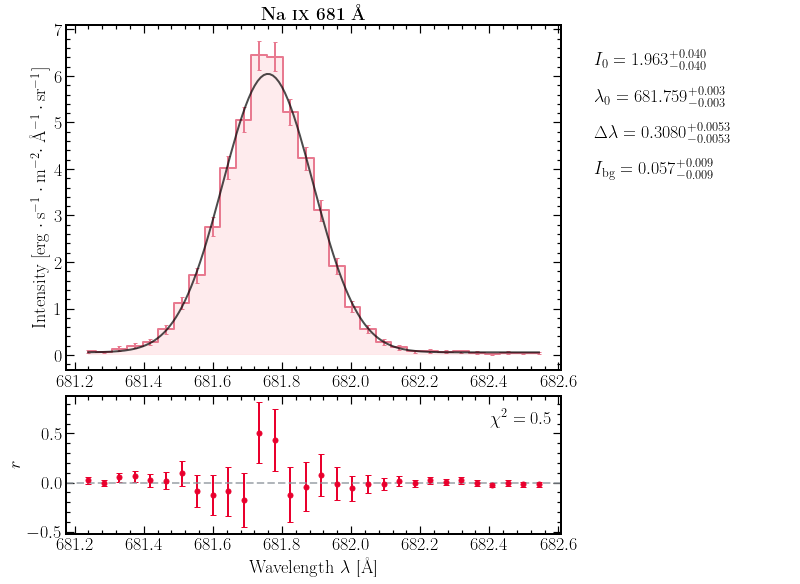

In [9]:
NaIX_681_slice = (210,240)
wvl_NaIX_681 = wvl_338[NaIX_681_slice[0]:NaIX_681_slice[1]]
radiometry_NaIX_681 = radiometry(1,681.75,1,1,bare=True,kbr=False,photons=False,watts=True,det_a=False,
                                det_b=True,joint=False,separate=True)*1e3

int_NaIX_681 = np.average(sumer_338_window[-30:,NaIX_681_slice[0]:NaIX_681_slice[1]],axis=0)*radiometry_NaIX_681
err_NaIX_681 = np.sqrt(np.sum(300*sumer_338_window[-30:,NaIX_681_slice[0]:NaIX_681_slice[1]],
                        axis=0))/30/300*radiometry_NaIX_681

NaIX_681_fit_model = SpectrumFitCustomPlot(data=int_NaIX_681,wvl=wvl_NaIX_681,err=err_NaIX_681,
                                      same_width=False,line_number=1,line_wvl_init=[681.8],
                                      int_max_init=[5],fwhm_init=[0.2])
#NaIX_681_fit_model.plot(plot_fit=False,plot_params=False)
NaIX_681_fit_model.run_HahnMC(n_chain=10000,absolute_sigma=True,save_chain=True)
NaIX_681_fit_model.plot(plot_title=r"\textbf{Na \textsc{ix} 681 \mbox{\AA}}",plot_hmc=True,
                        xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                        ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot m^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$")
print("FWHM after removing instrumental broadening: ",
con_width_funct_4(1,NaIX_681_fit_model.line_wvl_fit,1,NaIX_681_fit_model.fwhm_fit_hmc*1000,DET_B=True))

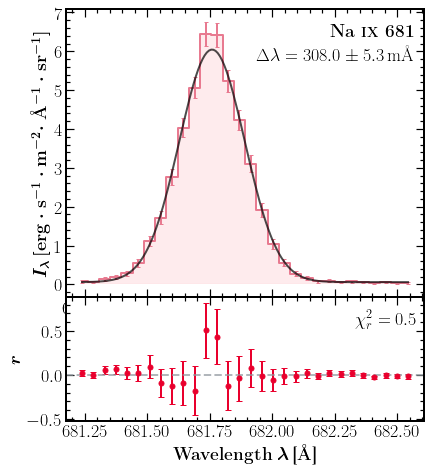

In [10]:
ax, ax_res = NaIX_681_fit_model.plot_custom(plot_hmc=True,plot_params=False,
    xlabel=r"\textbf{Wavelength} $\boldsymbol{\lambda}$\,\textbf{[\mbox{\AA}]}",
    ylabel=r"$\boldsymbol{I_\lambda\, \mathrm{[erg\cdot s^{-1}\cdot m^{-2}\cdot}}$ \textbf{\mbox{\AA}}$\boldsymbol{\mathrm{^{-1}\cdot sr^{-1}]}}$")

ax.text(0.97,0.95,r'\textbf{Na \textsc{ix} 681}',fontsize=18,transform=ax.axes.transAxes,ha="right",va="top")

ax.text(0.97,0.87,r'$\Delta \lambda = {:.1f}\pm{:.2g}$\,m\mbox{{\AA}}'.format(num2tex(NaIX_681_fit_model.fwhm_fit_hmc[0]*1e3),
num2tex(NaIX_681_fit_model.fwhm_err_hmc[0,0]*1e3)),fontsize=18,transform=ax.axes.transAxes,ha="right",va="top")
ax_res.set_ylabel(r"$\boldsymbol{r}$",fontsize=18)
plt.savefig(fname="../../figs/ms/NaIX_example.pdf",format="pdf")
